# Collaboration and Competition (MultiAgent)

<div style="text-align: right"><strong>Iván Vallés Pérez - October 2018</strong></div>

In this notebook, the Unity ML-Agents environment will be used to evaluate the [**MADDPG**](https://arxiv.org/abs/1706.02275) algorithm for multiagent training. This is a simple generalization of the **DDPG** algorithm, consisting of the following modifications:

- The concept of *centralized critic* is introduced, which simply consists of providing the information of the states and actions of all the agents to the critic of each agent. 
- The learned policy uses only local information at execution time (i.e. data coming only from the agent interaction with the environment), which means that there is no communication between agents required. 

![maddpg_architecture](../imgs/maddpg_architecture.png)
![maddpg_algorithm](../imgs/algorithm.png)

The neural networks implemented to solve this environment (both for the critic and for the agent) are simply Multi-Layer Perceptrons with 3 256-units hidden layers.

In [1]:
%cd ..
from unityagents import UnityEnvironment
import numpy as np
from src.agents import MADDPGAgent
from src.models import CriticArchitecture, ActorArchitecture
import matplotlib.pyplot as plt
from src.rl_utilities import plot_smoothed_return
from IPython.display import clear_output
import torch

## The tennis environment

The Unity 2D Tennis environment will be used to test our algorithm. In it, two agents control rackets to bounce a ball over a net. If an agent **hits the ball over the net**, it receives a **reward of +0.1**. If an **agent lets a ball hit the ground** or hits the ball out of bounds, it receives a **reward of -0.01**. Thus, **the goal of each agent is to keep the ball in play**.

The observation space consists of **8 variables** corresponding to **the position and velocity of the ball and racket**. Each agent receives its own local observation at execution time. **2 continuous actions** are available, corresponding to movement toward (or away from) the net, and jumping.

The task is **episodic**, and in order to solve the environment, your agents must get an **average score of +0.5 over 100 consecutive episodes**, after taking the maximum over both agents. Specifically,

- After each episode, we add up the rewards that each agent received (without discounting), to get a score for each agent. This yields 2 (potentially different) scores. We then take the maximum of these 2 scores.
- This yields a single score for each episode.

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"` [download](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P3/Tennis/Tennis.app.zip)
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"` [download](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P3/Tennis/Tennis_Windows_x86.zip)
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"` [download](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P3/Tennis/Tennis_Windows_x86_64.zip)
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"` [download](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P3/Tennis/Tennis_Linux.zip)
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"` [download](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P3/Tennis/Tennis_Linux.zip)
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"` [download](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P3/Tennis/Tennis_Linux_NoVis.zip)
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"` [download](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P3/Tennis/Tennis_Linux_NoVis.zip)

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="your filepath here!")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)

# size of each action
action_size = brain.vector_action_space_size

# size of the state space 
state_size = env_info.vector_observations.shape[1]

## Train

In [4]:
batch_size = 128  # Size of the batch to train the neural networks
n_episodes = 4000 # Number of episodes to run when training the agent
n_batches_train = 1 # Number of times to train for each time step
n_agents = 2 # Number of agents
exp_replay_buffer_size = int(1e5) # Experience replay buffer size
epsilon_decay =  1 # Decay of the exploration constant
epsilon = 1 # Initial value of the exploration constant
epsilon_final = 0.1 # Final value of the exploration constant
plot_every_n = 10 # Period to update the rewards chart
save_every_n = 1 # Period to save the model if an improvement has been found
tau = 0.02 # Parameter that controls how fast the local networks update the target networks
gamma = 0.99 # Discount factor

In [6]:
agent = MADDPGAgent(CriticArchitecture, ActorArchitecture, state_sizes=[state_size, state_size], 
                    action_sizes=[action_size, action_size], n_agents=n_agents,
                    tau=tau, gamma=gamma, batch_size=batch_size, 
                    replay_size = exp_replay_buffer_size,
                    n_batches_train=n_batches_train, random_seed=655321)
scores = [] 
epsilons = []
buffer_sizes = []
max_score = 0
actions_unique=set()

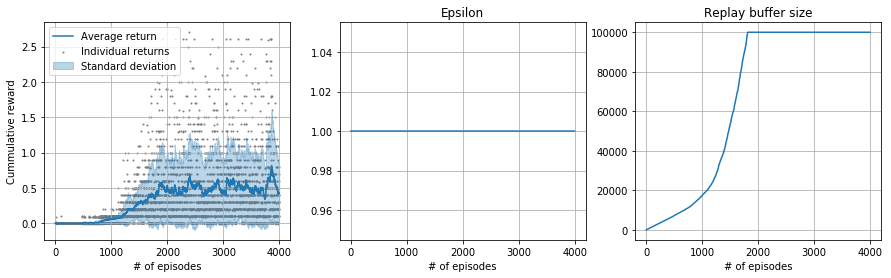

In [7]:
for episode in range(n_episodes):
    epsilons.append(epsilon)
    epsilon = epsilon_decay * epsilon + (1-epsilon_decay) * epsilon_final
    env_info = env.reset(train_mode=True)[brain_name] 
    agent.reset()
    state = env_info.vector_observations.tolist()
    score = []
    done = [False]
    c = 0
    while not any(done):
        # take random action
        action = agent.act(state, epsilon=epsilon)
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations.tolist()
        reward = env_info.rewards
        done = env_info.local_done
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += [reward]
        c += 1
        #actions_unique = actions_unique.union(set(np.unique(action)))

    scores.append(np.max(np.sum(score, axis=0)))
    buffer_sizes.append(agent.replay_buffer.length)
    
    if (episode+1) % plot_every_n == 0:
        clear_output(True)
        plt.figure(figsize=(15, 4))
        plt.subplot(1,3,1)
        plot_smoothed_return(scores)
        plt.subplot(1,3,2)
        plt.grid()
        plt.plot(epsilons)
        plt.xlabel("# of episodes")
        plt.title("Epsilon")
        plt.subplot(1,3,3)
        plt.grid()
        plt.plot(buffer_sizes)
        plt.xlabel("# of episodes")
        plt.title("Replay buffer size")
        plt.show()
        
    if (episode + 1) % save_every_n == 0:
        if max_score < np.mean(scores[-100:]): 
            for i, ddpg_agent in enumerate(agent.agents):
                torch.save(ddpg_agent.critic_local.state_dict(), f'./models/checkpoint_critic_local_tennis_{i}.pth')
                torch.save(ddpg_agent.critic_target.state_dict(), f'./models/checkpoint_critic_target_tennis_{i}.pth')
                torch.save(ddpg_agent.actor_local.state_dict(), f'./models/checkpoint_actor_local_tennis_{i}.pth')
                torch.save(ddpg_agent.actor_target.state_dict(), f'./models/checkpoint_actor_target_tennis_{i}.pth')
                max_score = np.mean(scores[-100:])

## Run the training process
The following code runs the training process, reports the cumulative reward, the epsilon evolution and the replay buffer size and finally saves the models weights of the best result

In [7]:
agent = MADDPGAgent(CriticArchitecture, ActorArchitecture, state_sizes=[state_size, state_size], 
                    action_sizes=[action_size, action_size], n_agents=n_agents,
                  tau=tau, gamma=gamma, batch_size=batch_size, replay_size = exp_replay_buffer_size,
                  n_batches_train=n_batches_train, random_seed=655321)
for i, ddpg_agent in enumerate(agent.agents):
    ddpg_agent.critic_local.load_state_dict(torch.load(f'./models/checkpoint_critic_local_tennis_{i}.pth'))
    ddpg_agent.critic_target.load_state_dict(torch.load(f'./models/checkpoint_critic_target_tennis_{i}.pth'))
    ddpg_agent.actor_local.load_state_dict(torch.load(f'./models/checkpoint_actor_local_tennis_{i}.pth'))
    ddpg_agent.actor_target.load_state_dict(torch.load(f'./models/checkpoint_actor_target_tennis_{i}.pth'))


In [10]:
rewards=[]
env_info = env.reset(train_mode=False)[brain_name] 
state = env_info.vector_observations
done=[False]
while not any(done):
    # take random action
    action = agent.act(state, epsilon=epsilon)
    env_info = env.step(action)[brain_name]
    state = env_info.vector_observations
    done = env_info.local_done
    reward = env_info.rewards
    rewards.append(reward)


C:\Users\Ivan Valles Perez\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Conclusions

The **MADDPG** algorithm demonstrated to perform well enough to successfully solve the environment. Both agents have been able to play the game and achieve >0.5 average return over the last 100 episodes. 
- The *tao* parameter has been found to be key for the algorithm to work well. *tao = 0.001* has been tested yielding undesired results, then it has been adjusted to *tao = 0.02*.
- No batch normalization has been used in order to keep the underlying neural networks as simple as possible (to discard potential issues).
- Smaller sizes of the neural nets have been tested, concluding that the current sizes are enough but not too big.

## Next steps

There are several points of improvement and next steps in the current implementation.
- In order to be able to compare these results with other algorithms, the randomness of the agent and environment must be taken into account. For that, several experiments with different random seeds must be run and the average results must be reported.
- In order to try to achieve a more natural movement of the rackets, a penalty for movements is proposed. The biological analogy of it would be the concept of **laziness**. Now, the agent does not have any penalty for doing wiggling or useless movements, penalizing high corrections (high accelerations) can potentially lead to more natural movement. One example of these useless movements could be the movements of the racket of an agent after successfully hitting the ball.
- The current setting motivates the agent to collaborate, but **no competition is promoted**. Giving reward when the contrary misses the ball could lead to interesting aggressive behaviors.
- *Batch Normalization* and *layer normalization* must be tested with the aim of improving the current results.